# Next time: try and remove 'nan' stars from consideration, or add the nice ones to a new array
### Might need to move the 'attitude detection' section in front of aperture photometry cell, so just don't do ap photom on the bad ones?
# Also calculate apparent mag of a star? (see Luke's thing)
# Also change name of 'final_data' maybe? gets a bit confusing

# Attempting some basic aperture photometry (yeet)

Based on method used in previous source detection test

First up, dependencies:

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from matplotlib.colors import LogNorm
#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize

Importing .fits file and extracting the ~ *data* ~:

In [16]:
image_file = 'example_data/PAL5_4p5um.fits'
image_data = fits.getdata(image_file, ext=0)
#print(image_data.shape)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
#data = hdu_list[0].data   # could open data here instead of fits.getdata above, more consistent
gain = hdr['GAIN']         # don't need gain any more
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
#print(gain, exptime, fluxconv)
hdu_list.close()

#data = image_data * exptime / fluxconv  # FLUXCONV in header is blank lol
data = image_data

#print(hdr)

Locating the objects in the image using DAOStarFinder, and plotting no. of stars detected vs. sigma curve:

In [17]:
#def detect_sources(data, sigma_level, FWHM):
#    daofind = DAOStarFinder(threshold = sigma_level * std, fwhm=FWHM)
#    sources = daofind(data - median)
#    return sources

In [18]:
mean, median, std = sigma_clipped_stats(data, sigma=3.) # don't need mean any more?

#detect_sources(data, sigma_level=5., FWHM=3.)
#for col in sources.colnames:
#    sources[col].info.format = '%.8g'
#print(sources)

#for i in range(1, 8):
#    detect_sources(data, sigma_level=float(i), FWHM=3.)
#    print(len(sources))

no_detected = []
sigma_vals = []
 
#for i in np.arange(1., 15.5, 0.5):
#    #print(i)
#    daofind = DAOStarFinder(threshold = i * std, fwhm = 3.)
#    sources = daofind(data - median)
#    #print(len(sources))
#    
#    no_detected.append(len(sources))
#    sigma_vals.append(i)
#
#print(no_detected)
#print(sigma_vals)

In [19]:
#plt.plot(sigma_vals, no_detected)
#plt.xlabel('sigma')
#plt.ylabel('number of sources detected')
#plt.grid(True)
#plt.savefig('images/sigma_curve_01.png', dpi=100)

Adding the centroid positions of the objects to an array and fitting circular apertures and annuli around them:

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


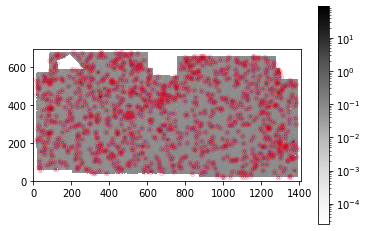

In [20]:
daofind = DAOStarFinder(threshold = 4. * std, fwhm = 3.)  # 4 sigma seems ideal to me
sources = daofind(data - median)

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.5)
annuli.plot(color='red', lw=.5, alpha=.5)

#plt.title('4 sigma')
#plt.savefig('images/sigma_4.png', dpi=500)

Performing some basic aperture photometry, summing the pixel brightness values (fluxes?) inside each aperture and annulus:

(Note: 'nan' values for apertures could be where the objects are too close to the edge of the image and use some pure white in their summation, and those for the annuli might be where annuli overlap?)

In [21]:
phot_table = aperture_photometry(data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id   xcenter   ycenter  aperture_sum_0 aperture_sum_1
        pix       pix                                 
---- --------- --------- -------------- --------------
   1 998.59804 20.106143            nan            nan
   2 1002.3643 20.474648            nan            nan
   3 1038.1681 20.564426            nan            nan
   4 1101.7978  20.78369            nan            nan
   5 1121.6704 21.384453            nan            nan
   6  1292.077 19.541266            nan            nan
   7 1355.4914 21.342649            nan            nan
   8 1349.2448 24.351963            nan            nan
   9 1146.7146 27.588916       11.93916            nan
  10 969.61924 27.947466      11.280463            nan
 ...       ...       ...            ...            ...
1120  516.9945 666.29554      16.915021            nan
1121 360.73032 668.33751      11.425296            nan
1122 549.47503 669.24791      9.1300477            nan
1123 258.85355 669.51997      9.2660823            nan
1124 453.6

Finding which star coordinates are giving me attitude and plotting them:

1036
93 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 17, 18, 19, 21, 28, 29, 30, 31, 32, 34, 38, 41, 57, 146, 219, 262, 300, 312, 398, 427, 445, 489, 631, 687, 718, 782, 789, 802, 823, 828, 860, 877, 896, 912, 926, 929, 930, 942, 956, 961, 968, 971, 973, 977, 982, 983, 984, 986, 999, 1006, 1030, 1037, 1047, 1056, 1063, 1086, 1090, 1091, 1092, 1093, 1094, 1095, 1097, 1098, 1104, 1106, 1107, 1108, 1113, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129]


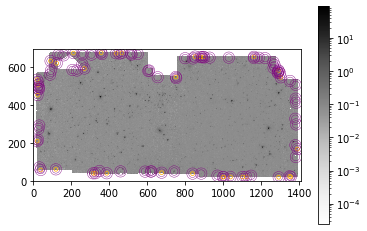

In [22]:
fail_test_x_ap = []
fail_test_y_ap = []
fail_test_x_an = []
fail_test_y_an = []
fail_test_id = []
nice_data = []

# could instead do annulus first, then 'elif' aperture
for i in range(0, len(phot_table)):
    if np.isnan(phot_table['aperture_sum_0'][i]) == True:
        fail_test_x_ap.append(phot_table['xcenter'][i].value)
        fail_test_y_ap.append(phot_table['ycenter'][i].value)
    if np.isnan(phot_table['aperture_sum_1'][i]) == True:
        fail_test_x_an.append(phot_table['xcenter'][i].value)
        fail_test_y_an.append(phot_table['ycenter'][i].value)
        fail_test_id.append(phot_table['id'][i])
    else:
        nice_data.append(phot_table[:][i])

fail_test_all_ap = np.column_stack((fail_test_x_ap, fail_test_y_ap))
fail_test_all_an = np.column_stack((fail_test_x_an, fail_test_y_an))
aperture_fails = CircularAperture(fail_test_all_ap, r=10.)
annulus_fails = CircularAnnulus(fail_test_all_an, r_in=20., r_out=30.)
#print(len(aperture_fails), len(annulus_fails))

#print(fail_test_all_ap)
#print(fail_test_all_an)
print(len(nice_data))
print(len(fail_test_id), fail_test_id)

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
aperture_fails.plot(color='orange', lw=.7, alpha=1.)
annulus_fails.plot(color='purple', lw=.4, alpha=1.)

#plt.savefig('images/ap_photom_fail_stars_04.png', dpi=500)

'nanmask' method creates a table of true/false values depending on which stars give me nans, and yeets them out of the data (~ operator inverts true -> false and vice-versa):

In [23]:
nanmask_ap = ~np.isnan(phot_table['aperture_sum_0'])
nanmask_an = ~np.isnan(phot_table['aperture_sum_1'])
final_data = phot_table[nanmask_an] # all nans in central apertures will also be present in the annuli, so can just base 
                                    # our data on the annuli masks (though implementing a check for both would be ideal)
print(final_data)

 id   xcenter   ycenter  aperture_sum_0 aperture_sum_1
        pix       pix                                 
---- --------- --------- -------------- --------------
  11 1116.7479 36.337246      9.0356473      40.682755
  12 970.56842 36.922336      9.3869244      40.354964
  13 1090.6396 37.639587      11.160105      45.678929
  16 1142.9103 40.451052      10.713521      38.490897
  20  904.5692  42.97976      10.927177      42.251613
  22 1078.2062 44.953432      9.6733763      38.879691
  23 1112.5492 44.587814      11.149421      40.690366
  24 1270.9334 45.938867      9.3893945      38.840714
  25 1049.6473 47.567795      10.144627      38.001819
  26 1098.2689 47.792524      12.730789      44.293058
 ...       ...       ...            ...            ...
1103 507.24945 652.36712      8.9424059      33.728857
1105 298.18634 653.86886      8.4124011      34.621213
1109 453.96006 657.56907       9.463879      28.921819
1110 490.60559 660.34346      9.2101732      33.512757
1111 118.6

Re-doing the aperture fittings ignoring the problem stars:

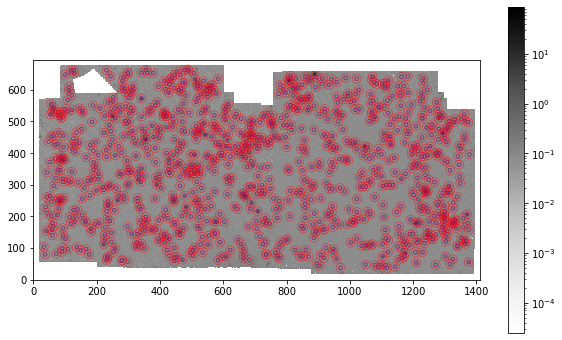

In [29]:
final_pos = np.transpose((final_data['xcenter'].value, final_data['ycenter'].value))
final_apertures = CircularAperture(final_pos, r=6.)
final_annuli = CircularAnnulus(final_pos, r_in=6., r_out=14.)
final_all_apers = [final_apertures, final_annuli]

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
final_apertures.plot(color='blue', lw=.75, alpha=.5)
final_annuli.plot(color='red', lw=.75, alpha=.5)
plt.gcf().set_size_inches(10, 6)

#plt.savefig('images/4p5um_4sigma_flux.png', dpi=300)

Estimating the local background in the annuli by finding the mean brightness within:

In [25]:
bkg_mean = final_data['aperture_sum_1'] / annuli.area
bkg_sum = bkg_mean * apertures.area
final_sum = final_data['aperture_sum_0'] - bkg_sum
final_data['residual_sum_mean'] = final_sum

#for col in final_data.colnames:
#    final_data[col].info.format = '%.8g'
print(final_data)

 id   xcenter   ycenter  aperture_sum_0 aperture_sum_1 residual_sum_mean
        pix       pix                                                   
---- --------- --------- -------------- -------------- -----------------
  11 1116.7479 36.337246      9.0356473      40.682755       -0.11797257
  12 970.56842 36.922336      9.3869244      40.354964        0.30705749
  13 1090.6396 37.639587      11.160105      45.678929        0.88234569
  16 1142.9103 40.451052      10.713521      38.490897         2.0530694
  20  904.5692  42.97976      10.927177      42.251613         1.4205636
  22 1078.2062 44.953432      9.6733763      38.879691        0.92544579
  23 1112.5492 44.587814      11.149421      40.690366         1.9940886
  24 1270.9334 45.938867      9.3893945      38.840714        0.65023379
  25 1049.6473 47.567795      10.144627      38.001819         1.5942177
  26 1098.2689 47.792524      12.730789      44.293058         2.7648508
 ...       ...       ...            ...            

Alternate method: better stats yay (sigma-clipped median in the annuli):

In [26]:
annulus_masks = final_annuli.to_mask(method='center') # note: exact would be overkill for local bkg estimation (read ap phot tutorial for explanation)

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
phot = aperture_photometry(data, final_apertures)
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * final_apertures.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']

for col in phot.colnames:
    phot[col].info.format = '%.8g'
print(phot)

 id   xcenter   ycenter  aperture_sum annulus_median  aper_bkg aper_sum_bkgsub
        pix       pix                                                         
---- --------- --------- ------------ -------------- --------- ---------------
   1 1116.7479 36.337246    9.0356473    0.076464657 8.6479489      0.38769836
   2 970.56842 36.922336    9.3869244    0.077685341 8.7860051      0.60091933
   3 1090.6396 37.639587    11.160105    0.082662974 9.3489621       1.8111427
   4 1142.9103 40.451052    10.713521    0.071621664 8.1002193       2.6133019
   5  904.5692  42.97976    10.927177    0.081794173  9.250703       1.6764736
   6 1078.2062 44.953432    9.6733763      0.0767194 8.6767597      0.99661666
   7 1112.5492 44.587814    11.149421    0.077247579 8.7364953       2.4129256
   8 1270.9334 45.938867    9.3893945    0.076656841 8.6696844      0.71971001
   9 1049.6473 47.567795    10.144627    0.074388538 8.4131454       1.7314815
  10 1098.2689 47.792524    12.730789    0.081723101

### ^^ Only problem here is the star ids have now changed, should try and keep them consistent if possible